<h1 style="padding:50px; color:white; background:#07D; font-size:48px; text-align:center; font-weight:bold;">
    Projet - OUTINFO
</h1>

<h2 style="padding:16px; color:white; background:#07D">Travail envisagé</h2>

**Données:**

- https://public.opendatasoft.com/explore/dataset/medecins/information/?flg=fr&location=8,48.49659,1.94733&basemap=jawg.light

Liste, localisation et tarifs des professionnels de santé en France en 2024.

Format : GeoJSON

<br>

- https://statistiques-locales.insee.fr/#c=indicator&i=filosofi.nbmenfisc&i2=filosofi.pimp&s=2021&s2=2021&selcodgeo=04&t=A01&t2=A01&view=map2

Statistiques locales en France: nombre d'habitants par zone, niveau de vie moyen par zone, espérance de vie, répartition de la population par âge, etc.

Format : CSV  
<br>

- https://www.regions-et-departements.fr/

Départements associés à leur région. \
Téléchargement des données en format PDF puis utilisation d'un convertisseur en ligne afin d'obtenir les données en format HTML.

Format : HTML

<br>
  
- https://www.openstreetmap.fr/

Les adjacences des communes françaises (avec une requête sql)

<br>



**Analyses envisagées:**

- Concentration des medecins par departement

- Comparer la concentration entre les zones rurales et urbaines

- Calculer le nombre de patient par medecin, à l'aide de leur localisation et de l'adjacence des communes

- Le montant constaté par séance par medecin par patient, et le niveau de revenu moyen de ses patients

<br> <br>

<h2 style="padding:16px; color:white; background:#07D">Imports</h2>


In [2]:
import numpy as np # import du package 'numpy' avec alias 'np'
import pandas as pd # import du package 'pandas' avec alias 'pd'
from SRC.tools import show, inspect  # import des fonctions du module 'tools'
from IPython.core.interactiveshell import InteractiveShell as ish

import matplotlib.pyplot as mp # import du package 'matplotlib' avec alias 'mp'
import seaborn as sb # import du package 'seaborn' avec alias 'sb'

from SRC.tools import show, load, fetch

from bs4 import BeautifulSoup
import requests

import geopandas as gpd

import requests
from io import StringIO

import folium
from IPython.display import display, HTML
from ipywidgets import interact, widgets

import re

import warnings; warnings.filterwarnings('ignore') # on enlève les 'warning' éventuels

<br> <br>

<h2 style="padding:16px; color:white; background:#07D">Etape 1 - Maillon fetch</h2>

<br> <br>

---
### 1 - Statistiques locales en France

<br>
Le fichier a été téléchargé, puis déposé sur GitHub, pour pouvoir y accéder à l'aide d'un url.

Les séparateurs sont '$;$' et les deux premières lignes sont à ignorer.

In [4]:
# URL GitHub pour le fichier CSV
url = "https://raw.githubusercontent.com/ahina0/projet_outinfo/main/statistiques.csv"

# Télécharger le fichier CSV depuis GitHub
response = requests.get(url)
response.raise_for_status()
    
# Charger les données dans un DataFrame
statistiques = pd.read_csv(StringIO(response.text), sep=';', skiprows=2)
statistiques

,Code,Libellé,Médecin généraliste (en nombre) 2023,Salaire net horaire moyen 2022,Chirurgien dentiste (en nombre) 2023,Population municipale 2022,Estimations de population 2024,Nb de pers. âgées de 65 ans ou + 2021,Nb de ménages fiscaux 2021,Médiane du niveau de vie 2021
0,01,Ain,435,15.96,321,671289,679498,121906,270138,24810
1,02,Aisne,372,14.46,226,525558,521632,111675,224492,20920
2,03,Allier,278,14.19,168,334715,332708,94477,160041,21500
3,04,Alpes-de-Haute-Provence,169,14.6,90,167179,168161,44383,72855,21790
4,05,Hautes-Alpes,182,13.99,89,141677,141661,36270,65683,22010
...,...,...,...,...,...,...,...,...,...,...
96,971,Guadeloupe,322,15.21,207,383569,378561,78607,N/A - résultat non disponible,N/A - résultat non disponible
97,972,Martinique,330,15.02,215,361019,349925,80027,147620,19770
98,973,Guyane,117,15.43,81,288382,295385,17149,N/A - résultat non disponible,N/A - résultat non disponible
99,974,La Réunion,857,14.26,539,881348,885700,112104,334396,17070


<br>

---
### 2 - Les départements et leur région

<br>

Le fichier a été téléchargé, puis déposé sur GitHub, pour pouvoir y accéder à l'aide d'un url. \
On récupère les données du fichier HTML qu'on enregistre dans un data frame. \
La première ligne du fichier HTML est le nom des colonnes, on l'utilise donc. On ne renomme pas la première colonne car on ne l'utilisera pas.

In [38]:
from bs4 import BeautifulSoup

# URL GitHub pour le fichier CSV
url = "https://raw.githubusercontent.com/ahina0/projet_outinfo/main/regions-et-departements-francais-converted.html"

# Télécharger le fichier HTML depuis GitHub
response = requests.get(url)
response.raise_for_status()


soup = BeautifulSoup(response.text, 'html.parser')

# step 2: identify the tags containing the data
# assume the data is in <tr> tags with <td> for each column
rows = soup.find_all('tr')

# step 3: extract and structure the data
data = []
for row in rows:
    cells = row.find_all('td')
    if len(cells) == 3:  # Number, Department, Region
        num = cells[0].get_text(strip=True)        # Number
        dept = cells[1].get_text(strip=True)       # Department
        region = cells[2].get_text(strip=True)     # Region
        data.append([num, dept, region])

# step 4: create a DataFrame with the extracted data
dept_region = pd.DataFrame(data)
dept_region.columns = dept_region.iloc[0]
dept_region = dept_region[1:].reset_index(drop=True)
dept_region

,‌NUMÉRODépartement,DÉPARTEMENT,RÉGION
0,01,Ain,Auvergne-Rhône-Alpes
1,02,Aisne,Hauts-de-France
2,03,Allier,Auvergne-Rhône-Alpes
3,04,Alpes-de-Haute-Provence,Provence-Alpes-Côte d'Azur
4,05,Hautes-Alpes,Provence-Alpes-Côte d'Azur
...,...,...,...
96,971,Guadeloupe,Guadeloupe
97,972,Martinique,Martinique
98,973,Guyane,Guyane
99,974,La Réunion,La Réunion


<br>

---
### 3 - Liste, localisation et tarifs des professionnels de santé en France.

<br>

Le fichier était trop lourd pour être téléchargé, et un url est directement disponible depuis la page web pour accéder à ces données. On utilise donc cet url. On a aussi uniquement sélectionné les données correspondant à "médecin généraliste", pour que le fichier soit moins lourd.

Comme le fichier est lourd, cette cellule est longue à s'exécuter.

In [8]:
import requests
import geopandas as gpd
from io import StringIO

# URL du fichier GeoJSON
url = "https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/medecins/exports/geojson?lang=fr&refine=libelle_profession%3A%22M%C3%A9decin%20g%C3%A9n%C3%A9raliste%22&timezone=Europe%2FBerlin"

# Télécharger le fichier GeoJSON
response = requests.get(url, stream=True)

# Charger le GeoJSON dans GeoPandas
geojson_data = response.text
professionnels_sante = gpd.read_file(StringIO(geojson_data))

# Afficher les premières lignes
professionnels_sante

Skipping field libelle_acte_clinique: unsupported OGR type: 5


,civilite,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,...,libelle_activite,libelle,tarif_1,tarif_2,remboursement,exoneration_tm,libelle_phase,tarif_base_de_remboursement_securite_sociale,concat,geometry
0,Homme,05.82.08.04.70,45,None,Libéral intégral,Secteur 1 ou conventionné,N,Lecteur de carte Sesam Vitale,G,NaN,...,None,None,None,None,None,NaN,None,NaN,VICTOR ANDERES 48 AVENUE MAURICE BOURGES MAUN...,POINT (1.45286 43.63905)
1,Femme,05.61.45.53.85,45,None,Libéral intégral,Secteur 1 ou conventionné,N,Lecteur de carte Sesam Vitale,CDRP0020,117.0,...,Opérateur Principal,Épreuves de dépistage de surdité avant l'âge d...,49.46,40.78,None,2.0,Une seule phase de traitement,49.46,EUGENIE DAGORN 2 RUE ANTOINE ST EXUPERY 3175...,POINT (1.5544 43.51914)
2,Femme,None,45,None,Libéral intégral,Secteur 1 ou conventionné,N,Lecteur de carte Sesam Vitale,G,NaN,...,None,None,None,None,None,NaN,None,NaN,SIMONA TORNEAN BP 40053 1 RUE RIXENS 31802 ST...,POINT (0.72106 43.10922)
3,Femme,None,45,None,Libéral intégral,Secteur 1 ou conventionné,N,Lecteur de carte Sesam Vitale,COE,NaN,...,None,None,None,None,None,NaN,None,NaN,SABRINE MELIANI 64 ALLEE DE BELLEFONTAINE 31...,POINT (1.39932 43.5658)
4,Femme,None,45,None,Libéral intégral,Secteur 1 ou conventionné,N,Lecteur de carte Sesam Vitale,JKHD0010,151.0,...,Opérateur Principal,Prélèvement cervicovaginal,12.73,9.8,None,2.0,Une seule phase de traitement,12.73,CATHY ARAUJO CABINET MEDICAL DU PERGET 2 AVENU...,POINT (1.30668 43.61298)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263386,Femme,03.22.92.98.34,45,Acupuncteur,Libéral intégral,"Secteur 2, Signature du contrat d'accès aux soins",O,Lecteur de carte Sesam Vitale,G,NaN,...,None,None,None,None,None,NaN,None,NaN,GENEVIEVE DIDELET 93 RUE VATABLE 80090 AMIENS,POINT (2.32052 49.88436)
263387,Femme,03.22.48.00.00,45,None,Libéral intégral,Secteur 1 ou conventionné,N,Lecteur de carte Sesam Vitale,G,NaN,...,None,None,None,None,None,NaN,None,NaN,MARIE CLAIRE MASQUELIER MAISON DE SANTE PLACE ...,POINT (2.52474 50.0125)
263388,Femme,03.22.88.49.50,45,None,Libéral intégral,Secteur 1 ou conventionné,N,Lecteur de carte Sesam Vitale,CCE,NaN,...,None,None,None,None,None,NaN,None,NaN,ANGELIQUE DEBEAULIEU MSP DE CONTOIRE HAMEL 104...,POINT (2.547 49.72177)
263389,Homme,03.22.51.45.64,45,None,Libéral intégral,Secteur 1 ou conventionné,N,Lecteur de carte Sesam Vitale,G,NaN,...,None,None,None,None,None,NaN,None,NaN,PIERRE CHARRIERCABINET MEDICAL 3 PLACE DE L E...,POINT (2.14993 49.95316)


### <br> <br>

<h2 style="padding:16px; color:white; background:#07D">Etape 2 - Maillons clean et structure</h2>

<br> <br>

---
### 1 -  Statistiques locales en France. 

<br>

Le nombre de chirurgiens dentistes n'est d'aucune utilité, car les chirurgiens dentistes ne figurent pas dans la database sur les professionnels de santé. On supprime donc cette colonne.

On renomme la colonne du nombre de médecins généralistes en 2023 pour plus de conveniance.

In [99]:
statistiques = statistiques.drop(columns=["Chirurgien dentiste (en nombre) 2023"]) # drop the specified column
statistiques = statistiques.rename(columns = {"Médecin généraliste (en nombre) 2023":"nb_medecins_2023"})
statistiques.head() # display the first rows

,Code,Libellé,nb_medecins_2023,Salaire net horaire moyen 2022,Population municipale 2022,Estimations de population 2024,Nb de pers. âgées de 65 ans ou + 2021,Nb de ménages fiscaux 2021,Médiane du niveau de vie 2021
0,01,Ain,435,15.96,671289,679498,121906,270138,24810
1,02,Aisne,372,14.46,525558,521632,111675,224492,20920
2,03,Allier,278,14.19,334715,332708,94477,160041,21500
3,04,Alpes-de-Haute-Provence,169,14.6,167179,168161,44383,72855,21790
4,05,Hautes-Alpes,182,13.99,141677,141661,36270,65683,22010


<br>

---
### 2 -  Les départements et leur région

<br>

On ajoute la colonne des régions à la data frame des statistiques locales françaises. Les départements sont déjà dans l'ordre croissant de leur numéro dans les deux data frame, donc aucune manipulation supplémentaire n'est nécéssaire.


In [11]:
statistiques['Région'] = dept_region.RÉGION # the "RÉGION" column in dept_region is added to statistiques
statistiques.head() #display the first rows

,Code,Libellé,Médecin généraliste (en nombre) 2023,Salaire net horaire moyen 2022,Population municipale 2022,Estimations de population 2024,Nb de pers. âgées de 65 ans ou + 2021,Nb de ménages fiscaux 2021,Médiane du niveau de vie 2021,Région
0,01,Ain,435,15.96,671289,679498,121906,270138,24810,Auvergne-Rhône-Alpes
1,02,Aisne,372,14.46,525558,521632,111675,224492,20920,Hauts-de-France
2,03,Allier,278,14.19,334715,332708,94477,160041,21500,Auvergne-Rhône-Alpes
3,04,Alpes-de-Haute-Provence,169,14.6,167179,168161,44383,72855,21790,Provence-Alpes-Côte d'Azur
4,05,Hautes-Alpes,182,13.99,141677,141661,36270,65683,22010,Provence-Alpes-Côte d'Azur


<br>

---
### 3 -  Liste, localisation et tarifs des professionnels de santé en France. 

<br>

Les colonnes ayant un nom de type "column_*number*" ne sont pas gardées, sauf "column_10", qui est le numéro de téléphone du médecin. On renomme cette colonne, et on supprime les autres.

In [9]:
professionnels_sante.rename(columns={"column_10": "numero_telephone"}, inplace=True)# rename the column

# keep only columns that do not match the pattern 'column_"number"'
filtered_columns = [col for col in professionnels_sante.columns if not col.startswith("column_")]
professionnels_sante = professionnels_sante[filtered_columns]

professionnels_sante.head()

,civilite,numero_telephone,nom,adresse,libelle_profession,type_dacte_realise,nom_acte,coordonnees,commune,code_insee,...,libelle_activite,libelle,tarif_1,tarif_2,remboursement,exoneration_tm,libelle_phase,tarif_base_de_remboursement_securite_sociale,concat,geometry
0,Homme,05.82.08.04.70,VICTOR ANDERES,48 AVENUE MAURICE BOURGES MAUNOURY 31200 TOUL...,Médecin généraliste,Acte clinique,None,None,Toulouse,31555,...,None,None,None,None,None,NaN,None,NaN,VICTOR ANDERES 48 AVENUE MAURICE BOURGES MAUN...,POINT (1.45286 43.63905)
1,Femme,05.61.45.53.85,EUGENIE DAGORN,2 RUE ANTOINE ST EXUPERY 31750 ESCALQUENS,Médecin généraliste,Acte technique,"Exploration de l'audition, de l'équilibre et d...",None,Escalquens,31169,...,Opérateur Principal,Épreuves de dépistage de surdité avant l'âge d...,49.46,40.78,None,2.0,Une seule phase de traitement,49.46,EUGENIE DAGORN 2 RUE ANTOINE ST EXUPERY 3175...,POINT (1.5544 43.51914)
2,Femme,None,SIMONA TORNEAN,BP 40053 1 RUE RIXENS 31802 ST GAUDENS CEDEX,Médecin généraliste,Acte clinique,None,None,Saint-Gaudens,31483,...,None,None,None,None,None,NaN,None,NaN,SIMONA TORNEAN BP 40053 1 RUE RIXENS 31802 ST...,POINT (0.72106 43.10922)
3,Femme,None,SABRINE MELIANI,64 ALLEE DE BELLEFONTAINE 31100 TOULOUSE,Médecin généraliste,Acte clinique,None,None,Toulouse,31555,...,None,None,None,None,None,NaN,None,NaN,SABRINE MELIANI 64 ALLEE DE BELLEFONTAINE 31...,POINT (1.39932 43.5658)
4,Femme,None,CATHY ARAUJO,CABINET MEDICAL DU PERGET 2 AVENUE ANDRE MARIE...,Médecin généraliste,Acte technique,Ponction et biopsie de l'appareil génital fémi...,None,Colomiers,31149,...,Opérateur Principal,Prélèvement cervicovaginal,12.73,9.8,None,2.0,Une seule phase de traitement,12.73,CATHY ARAUJO CABINET MEDICAL DU PERGET 2 AVENU...,POINT (1.30668 43.61298)


<br>

On ne garde que les colonnes qui nous intéressent pour les analyses.

On visualise les colonnes restantes :

In [10]:
professionnels_sante.columns # visualisation of the remaining columns

Index(['civilite', 'numero_telephone', 'nom', 'adresse', 'libelle_profession',
       'type_dacte_realise', 'nom_acte', 'coordonnees', 'commune',
       'code_insee', 'epci_name', 'dep_name', 'reg_name', 'epci_code',
       'reg_code', 'dep_code', 'activite_principale', 'code', 'phase',
       'libelle_regroupement', 'accord_prealable', 'code_ccam_activite_phase',
       'regroupement', 'libelle_activite', 'libelle', 'tarif_1', 'tarif_2',
       'remboursement', 'exoneration_tm', 'libelle_phase',
       'tarif_base_de_remboursement_securite_sociale', 'concat', 'geometry'],
      dtype='object')

<br>

La colonne "libelle_profession" est inutile, car on a conservé que les lignes qui correspondent aux médecins généralistes dans la base de données initiale.

Pour plus de complexité à traiter les données, on décide de ne pas conserver les colonnes de la commune, du département et de la région. On créera la colonne du département à partir de la colonne adresse.

Pour identifier un médecin, on utilisera son nom et son numéro de téléphone.

On ne conserve donc que les colonnes sur le nom, numéro de téléphone, genre et adresse du médecin, ainsi que le tarif et le type de la consultation.

In [11]:
columns_to_keep = ["nom", "numero_telephone", "civilite", "adresse", "tarif_1", "tarif_2", "remboursement", "tarif_base_de_remboursement_securite_sociale", "type_dacte_realise"] # the columns to keep
professionnels_sante = professionnels_sante[columns_to_keep]

professionnels_sante.head(20)

,nom,numero_telephone,civilite,adresse,tarif_1,tarif_2,remboursement,tarif_base_de_remboursement_securite_sociale,type_dacte_realise
0,VICTOR ANDERES,05.82.08.04.70,Homme,48 AVENUE MAURICE BOURGES MAUNOURY 31200 TOUL...,None,None,None,NaN,Acte clinique
1,EUGENIE DAGORN,05.61.45.53.85,Femme,2 RUE ANTOINE ST EXUPERY 31750 ESCALQUENS,49.46,40.78,None,49.46,Acte technique
2,SIMONA TORNEAN,None,Femme,BP 40053 1 RUE RIXENS 31802 ST GAUDENS CEDEX,None,None,None,NaN,Acte clinique
3,SABRINE MELIANI,None,Femme,64 ALLEE DE BELLEFONTAINE 31100 TOULOUSE,None,None,None,NaN,Acte clinique
4,CATHY ARAUJO,None,Femme,CABINET MEDICAL DU PERGET 2 AVENUE ANDRE MARIE...,12.73,9.8,None,12.73,Acte technique
5,MARINE MAUDUIT,05.61.82.64.64,Femme,37 RUE DES FLEURS 31150 BRUGUIERES,None,None,None,NaN,Acte clinique
6,GEORGETA ELENA VIRTOPEANU,None,Femme,4 RUE FELIX SICARD 31140 MONTBERON,None,None,None,NaN,Acte clinique
7,PHILIPPE PORTIA,None,Homme,48 RUE DES ANGES 31200 TOULOUSE,14.52,13.66,None,14.52,Acte technique
8,MARIE PERREARD,None,Femme,10 SQUARE JOSEPHINE BAKER 31320 CASTANET TOLOSAN,None,None,None,NaN,Acte clinique
9,VANESSA SAUREL,05.61.91.94.31,Femme,LOT LES PORTES DU SAVES 3 PLACE COMPARIOL 314...,69.12,69.12,None,69.12,Acte technique


<br>

On remarque que beaucoup de valeurs de la colonne "remboursement" semblent avoir la valeur "None". On compte le nombre de ces valeurs pour décider de garder cette colonne ou non.

Pourcentage de valeurs None dans la colonne remboursement : 99%.


<Axes: xlabel='remboursement'>

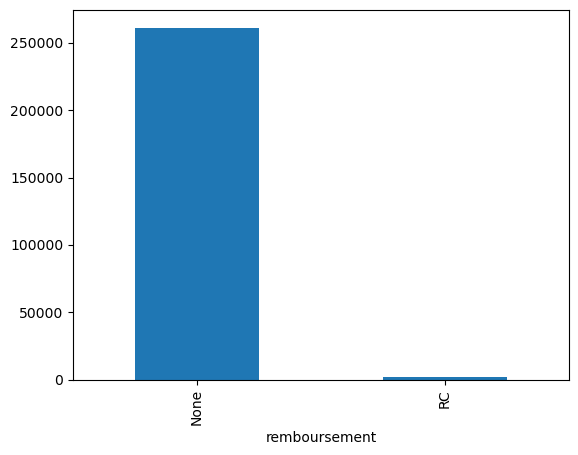

In [12]:
# count the number of None values in the "remboursement" column. It is either Na or "None"
none_count = professionnels_sante[(professionnels_sante["remboursement"].isna()) | (professionnels_sante["remboursement"] == "None")].shape[0]
total_rows = professionnels_sante.shape[0] # count the number of rows in the dataframe
print(f"Pourcentage de valeurs None dans la colonne remboursement : {(none_count/total_rows)*100:.0f}%.") # prints the percentage of None values, with no decimal

professionnels_sante["remboursement"] = professionnels_sante["remboursement"].fillna("None") # if Na, write "None"
# display the repartition of the values of the remboursement column
professionnels_sante.groupby("remboursement").count()["civilite"].plot.bar()

On décide de supprimer cette colonne.

In [13]:
professionnels_sante = professionnels_sante.drop(columns=["remboursement"])
professionnels_sante.head()

,nom,numero_telephone,civilite,adresse,tarif_1,tarif_2,tarif_base_de_remboursement_securite_sociale,type_dacte_realise
0,VICTOR ANDERES,05.82.08.04.70,Homme,48 AVENUE MAURICE BOURGES MAUNOURY 31200 TOUL...,None,None,NaN,Acte clinique
1,EUGENIE DAGORN,05.61.45.53.85,Femme,2 RUE ANTOINE ST EXUPERY 31750 ESCALQUENS,49.46,40.78,49.46,Acte technique
2,SIMONA TORNEAN,None,Femme,BP 40053 1 RUE RIXENS 31802 ST GAUDENS CEDEX,None,None,NaN,Acte clinique
3,SABRINE MELIANI,None,Femme,64 ALLEE DE BELLEFONTAINE 31100 TOULOUSE,None,None,NaN,Acte clinique
4,CATHY ARAUJO,None,Femme,CABINET MEDICAL DU PERGET 2 AVENUE ANDRE MARIE...,12.73,9.8,12.73,Acte technique


<br>

Les colonnes tarif_1 et tarif_2 sont de type chaine de charactères. On les convertit en chiffres.

In [14]:
# ensure columns tarif_1 and tarif_2 are converted to numbers
professionnels_sante["tarif_1"] = pd.to_numeric(professionnels_sante["tarif_1"], errors="coerce")
professionnels_sante["tarif_2"] = pd.to_numeric(professionnels_sante["tarif_2"], errors="coerce")

<br>

Les colonnes tarif_1 et tarif_base_de_remboursement_securite_sociale semblent avoir des valeurs très proches. On calcule la différence entre les deux, et on vérifie si lorsqu'une valeur n'est pas renseignée, l'autre ne l'est pas non plus.

On fait de même pour tarif_1 et tarif_2.

In [15]:
# calculate the difference between tarif_1 and tarif_base_de_remboursement_securite_sociale
ecart = pd.DataFrame({"difference_remboursement": professionnels_sante["tarif_1"] - professionnels_sante["tarif_base_de_remboursement_securite_sociale"]})
print(f"Moyenne de la différence entre le tarif et la base de remboursement : {ecart["difference_remboursement"].mean():.2f}") # display the mean of the difference, ignoring NaN values

none_and_number_count = (
    (professionnels_sante["tarif_1"].isna() & professionnels_sante["tarif_base_de_remboursement_securite_sociale"].notna()) |
    (professionnels_sante["tarif_1"].notna() & professionnels_sante["tarif_base_de_remboursement_securite_sociale"].isna())
).sum() # count rows where one column is NaN and the other is a number

print(f"Nombre de lignes où une seule des deux valeurs est renseignée: {none_and_number_count}")

Moyenne de la différence entre le tarif et la base de remboursement : 0.09
Nombre de lignes où une seule des deux valeurs est renseignée: 0


<br>

On considère donc que les deux colonnes sont identiques.

On compare maintenant les colonnes tarif_1 et tarif_2.

In [16]:
# calculate the difference between tarif_1 and tarif_2
ecart = pd.DataFrame({"difference_tarifs": professionnels_sante["tarif_1"] - professionnels_sante["tarif_2"]})
print(f"Moyenne de la différence entre les deux tarifs : {ecart["difference_tarifs"].mean():.2f}") # display the mean of the difference, ignoring NaN values

none_and_number_count = (
    (professionnels_sante["tarif_1"].isna() & professionnels_sante["tarif_2"].notna()) |
    (professionnels_sante["tarif_1"].notna() & professionnels_sante["tarif_2"].isna())
).sum() # count rows where one column is NaN and the other is a number

print(f"Nombre de lignes où une seule des deux valeurs est renseignée: {none_and_number_count}")

Moyenne de la différence entre les deux tarifs : 2.15
Nombre de lignes où une seule des deux valeurs est renseignée: 0


<br>

L'écart entre les deux colonnes est de nouveau faible, et on a toujours les deux valeurs, ou aucune des deux.

On choisit donc de ne garder que la colonne tarif_1 parmis les trois.

In [17]:
professionnels_sante = professionnels_sante.drop(columns=["tarif_2", "tarif_base_de_remboursement_securite_sociale"]) # delete the unnecessary columns
professionnels_sante.head()

,nom,numero_telephone,civilite,adresse,tarif_1,type_dacte_realise
0,VICTOR ANDERES,05.82.08.04.70,Homme,48 AVENUE MAURICE BOURGES MAUNOURY 31200 TOUL...,NaN,Acte clinique
1,EUGENIE DAGORN,05.61.45.53.85,Femme,2 RUE ANTOINE ST EXUPERY 31750 ESCALQUENS,49.46,Acte technique
2,SIMONA TORNEAN,None,Femme,BP 40053 1 RUE RIXENS 31802 ST GAUDENS CEDEX,NaN,Acte clinique
3,SABRINE MELIANI,None,Femme,64 ALLEE DE BELLEFONTAINE 31100 TOULOUSE,NaN,Acte clinique
4,CATHY ARAUJO,None,Femme,CABINET MEDICAL DU PERGET 2 AVENUE ANDRE MARIE...,12.73,Acte technique


<br>

On regarde maintenant le pourcentage de valeurs manquantes : 

In [18]:
none_count = (professionnels_sante["tarif_1"].isna()).sum() # count rows where the two values are NaN
print(f"Pourcentage de valeurs non renseignées: {none_count/total_rows*100:.0f}%")

Pourcentage de valeurs non renseignées: 62%


<br>

Il y a un nombre assez élevé de valeurs non renseignées, mais il y en a quand même assez pour faire des analyses sur les tarifs.

<br>

On souhaite maintenant connaître le départment des professionnels de santé. On crée donc une colonne "dep_code", qui contiendra le code du département dans lequel exerce le médecin, à partir de son adresse.

In [19]:
special_deps = {"971", "972", "973", "974", "975", "976", "977", "978", "984", "986", "987", "988", "989"}

def extract_dep_code(adress):
    '''returns the department code of the given adress'''
    match = re.search(r"\d{5}", str(adress)) # 5 digits in address
    if not match: return None
    postal_code = match.group(0) # the postal code
    # determine the depatment code
    if postal_code[:3] in special_deps:
        return postal_code[:3] # a special department code is 3 digits
    return postal_code[:2] # else it is only 2 digits

# create the column with the department code
professionnels_sante["dep_code"] = professionnels_sante["adresse"].apply(extract_dep_code)
# the adress column is now useless
professionnels_sante = professionnels_sante.drop(columns= ["adresse"])

professionnels_sante.head()

,nom,numero_telephone,civilite,tarif_1,type_dacte_realise,dep_code
0,VICTOR ANDERES,05.82.08.04.70,Homme,NaN,Acte clinique,31
1,EUGENIE DAGORN,05.61.45.53.85,Femme,49.46,Acte technique,31
2,SIMONA TORNEAN,None,Femme,NaN,Acte clinique,40
3,SABRINE MELIANI,None,Femme,NaN,Acte clinique,31
4,CATHY ARAUJO,None,Femme,12.73,Acte technique,31



<br>

Il y a plusieurs lignes par médecin dans les données. On ne veut qu'une seule ligne par médecin pour pouvoir ensuite compter le nombre de médecin par département. On identifie un médecin par son nom, et aussi par le numéro de téléphone en cas d'homonyme.

Cependant, pour traiter les tarifs, on veut séparer par type d'acte réalisé. On va donc créer une nouvelle data frame où il y a deux lignes par médecin, si il effectue les deux types d'actes.

<br>

La base de données sur les médecins :

In [20]:
medecins = professionnels_sante[["nom", "numero_telephone", "civilite", "dep_code"]] # select the wanted rows
# fo the department and the gender, we suppose the value is the same on all rows for each doctor
medecins = medecins.groupby(["nom", "numero_telephone"], as_index=False).first() # a doctor is identified by his name and phone number
medecins.head()

,nom,numero_telephone,civilite,dep_code
0,ABALAKERIM SIBELKHIR,03.21.71.62.89,Homme,62
1,ABAS GHULAM,03.88.29.67.00,Homme,67
2,ABBAS KHENNOUF,04.77.33.00.36,Homme,42
3,ABD SAMAD AIFOUTE,04.67.75.15.53,Homme,34
4,ABDALLAH ABDELLI,01.34.20.96.96,Homme,95


<br>

La base de données sur les tarifs en fonction du type d'acte :

In [39]:
tarifs = professionnels_sante[["nom", "numero_telephone", "dep_code", "tarif_1", "type_dacte_realise"]] # select the wanted rows
# a doctor is identified by its name and phone number, and we want to separate the values of type_dacte_realise
tarifs = tarifs.groupby(["nom", "numero_telephone", "type_dacte_realise"], as_index=False).agg({
    "tarif_1": "mean", # the value of "tarif_1" is the mean of all the values for a type of act for a doctor
    "dep_code": "first"  # keep the first value of "dep_code" as we suppose it is always the same for a doctor
})
tarifs.head()

,nom,numero_telephone,type_dacte_realise,tarif_1,dep_code
0,ABALAKERIM SIBELKHIR,03.21.71.62.89,Acte clinique,NaN,62
1,ABALAKERIM SIBELKHIR,03.21.71.62.89,Acte technique,69.12,62
2,ABAS GHULAM,03.88.29.67.00,Acte clinique,NaN,67
3,ABAS GHULAM,03.88.29.67.00,Acte technique,14.52,67
4,ABBAS KHENNOUF,04.77.33.00.36,Acte clinique,NaN,42


### <br> <br>

<h2 style="padding:16px; color:white; background:#07D">Etape 3 - Maillons model et analyse</h2>

<br> <br>

---
### 1 -  Répartition des médecins généralistes par département

<br>

On crée une table contenant le nombre de médecins par département, ainsi que la répartition hommes femmes.

In [22]:
medecins_par_dep = medecins.groupby("dep_code").size().rename("count") # count the total number of doctors per department

# the percentage of men and women doctors per department
repartition_par_dep = medecins.groupby(["dep_code", "civilite"]).size().unstack(fill_value=0)
repartition_par_dep = repartition_par_dep.div(repartition_par_dep.sum(axis=1), axis=0)*100
repartition_par_dep = repartition_par_dep.round().astype(int) # rounded up percentages without decimal

repartition = pd.concat([medecins_par_dep, repartition_par_dep], axis=1) # the repartition per department table
repartition = repartition.reset_index(drop=False) # reset the index for a clean output

repartition.head()

,dep_code,count,Femme,Homme
0,01,316,49,51
1,02,240,33,67
2,03,204,48,52
3,04,124,37,63
4,05,130,52,48


In [ ]:
Calcul de la moyenne du nombre de médecins généralistes par régions en 2023

In [7]:
df = pd.DataFrame(table)

# Calcul de la moyenne du nombre de médecins généralistes par région
moyennes_par_region = df.groupby("Région")["Médecin généraliste (en nombre) 2023"].mean()

# Affichage des résultats
print(moyennes_par_region)


Région
Auvergne-Rhône-Alpes           606.333333
Bourgogne-Franche-Comté        210.375000
Bretagne                       548.750000
Centre-Val de Loire            293.333333
Corse                          484.500000
Grand Est                      488.700000
Guadeloupe                     322.000000
Guyane                         117.000000
Hauts-de-France               1024.600000
Ile-de-France                 1135.250000
La Réunion                     857.000000
Martinique                     330.000000
Mayotte                         31.000000
Normandie                      649.800000
Nouvelle-Aquitaine             552.166667
Occitanie                      451.769231
Pays de la Loire               632.800000
Provence-Alpes-Côte d'Azur     984.500000
Name: Médecin généraliste (en nombre) 2023, dtype: float64


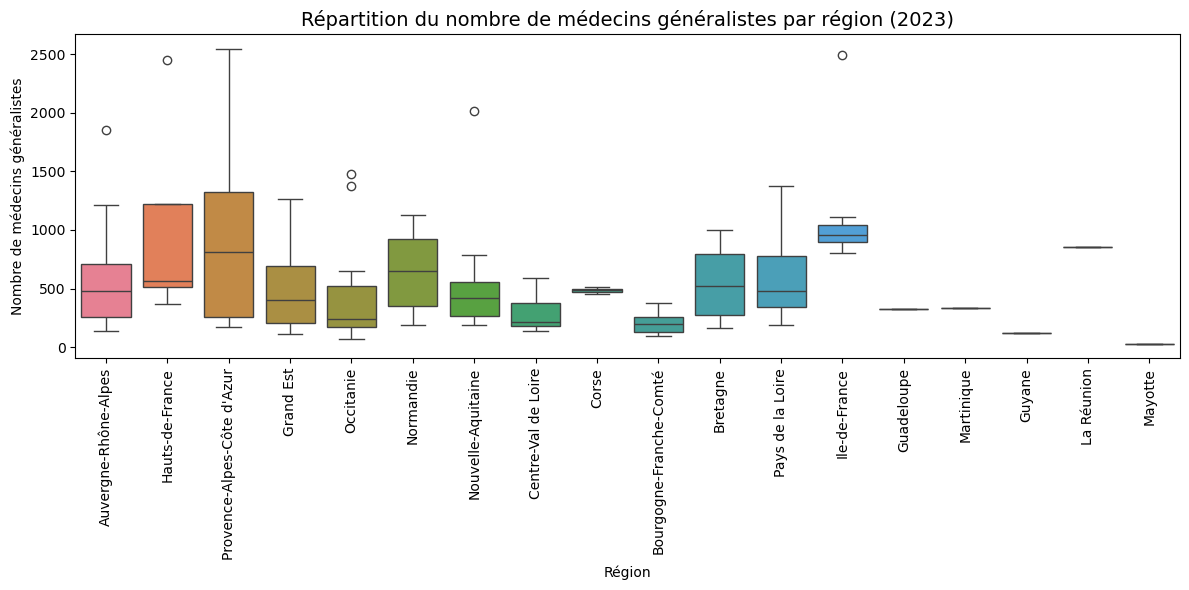

In [11]:
# Créer le graphique en boîtes à moustaches avec des couleurs différentes
mp.figure(figsize=(12, 6))
palette = sb.color_palette("husl", len(table["Région"].unique()))  # Génère une palette de couleurs unique

sb.boxplot(
    x="Région",
    y="Médecin généraliste (en nombre) 2023",
    data=table,
    palette=palette
)

# Personnalisation du graphique
mp.title("Répartition du nombre de médecins généralistes par région (2023)", fontsize=14)
mp.xticks(rotation=90)
mp.xlabel("Région")
mp.ylabel("Nombre de médecins généralistes")
mp.tight_layout()

# Afficher le graphique
mp.show()


Attention : certains départements n'ont pas été associés à une région.


<Figure size 1200x600 with 0 Axes>

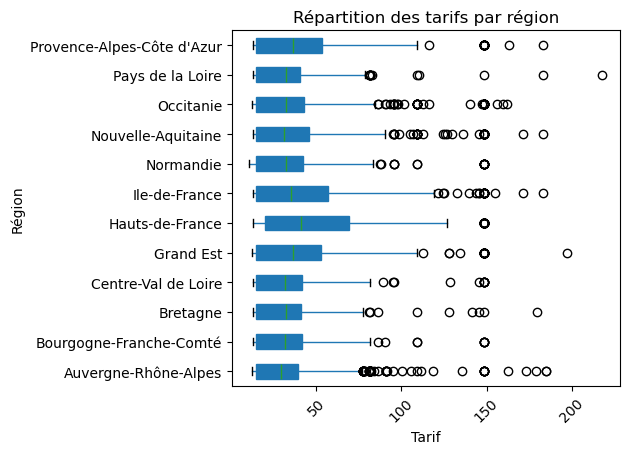

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

#DÉPARTEMENT	RÉGION

# Fusion des deux tables sur le code département (en s'assurant de la correspondance des formats)
dept_region['‌NUMÉRODépartement'] = dept_region['‌NUMÉRODépartement'].astype(str)
tarifs['dep_code'] = tarifs['dep_code'].astype(str)

data_merged = tarifs.merge(dept_region, left_on='dep_code', right_on='‌NUMÉRODépartement', how='left')

# Vérification de la fusion
if data_merged['RÉGION'].isnull().any():
    print("Attention : certains départements n'ont pas été associés à une région.")

# Création du graphique en boîtes à moustaches
plt.figure(figsize=(12, 6))
data_merged.boxplot(column='tarif_1', by='RÉGION', grid=False, vert=False, patch_artist=True)

# Personnalisation du graphique
plt.title("Répartition des tarifs par région")
plt.suptitle("")  # Supprimer le titre automatique ajouté par `boxplot`
plt.xlabel("Tarif")
plt.ylabel("Région")

# Rotation des labels si nécessaire (adapté pour les longues listes de régions)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [54]:
data_merged

,nom,numero_telephone,type_dacte_realise,tarif_1,dep_code,‌NUMÉRODépartement,DÉPARTEMENT,RÉGION,DÉPARTEMENTT
0,ABALAKERIM SIBELKHIR,03.21.71.62.89,Acte clinique,NaN,62,62,Pas-de-Calais,Hauts-de-France,Pas-de-Calais
1,ABALAKERIM SIBELKHIR,03.21.71.62.89,Acte technique,69.120000,62,62,Pas-de-Calais,Hauts-de-France,Pas-de-Calais
2,ABAS GHULAM,03.88.29.67.00,Acte clinique,NaN,67,67,Bas-Rhin,Grand Est,Bas-Rhin
3,ABAS GHULAM,03.88.29.67.00,Acte technique,14.520000,67,67,Bas-Rhin,Grand Est,Bas-Rhin
4,ABBAS KHENNOUF,04.77.33.00.36,Acte clinique,NaN,42,42,Loire,Auvergne-Rhône-Alpes,Loire
...,...,...,...,...,...,...,...,...,...
60831,ZOULIKHA EL KECHAI TADRIST,04.90.44.91.44,Acte clinique,NaN,13,13,Bouches-du-Rhône,Provence-Alpes-Côte d'Azur,Bouches-du-Rhône
60832,ZOULIKHA EL KECHAI TADRIST,04.90.44.91.44,Acte technique,62.700000,13,13,Bouches-du-Rhône,Provence-Alpes-Côte d'Azur,Bouches-du-Rhône
60833,ZUBAIR MAQSOOD,07.51.01.01.47,Acte clinique,NaN,95,95,Val-D'Oise,Ile-de-France,Val-D'Oise
60834,ZULAY MARCELIS,04.67.92.59.70,Acte clinique,NaN,34,34,Hérault,Occitanie,Hérault


Attention : certains départements n'ont pas été associés à une région.


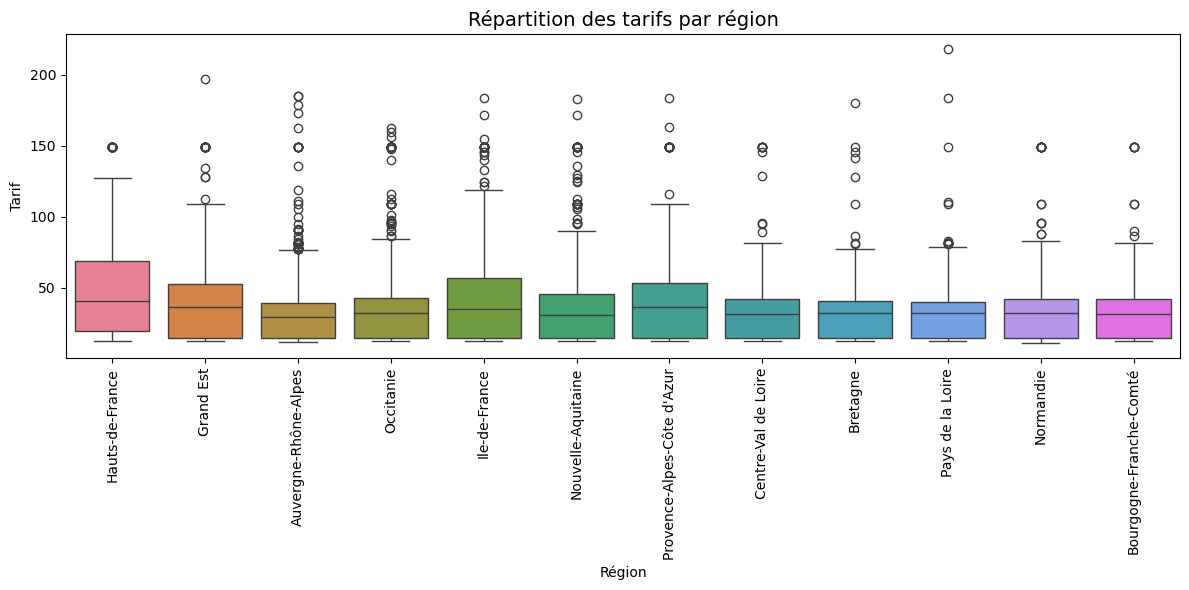

In [66]:
import seaborn as sb
import matplotlib.pyplot as mp

# Fusion des deux tables sur le code département (en s'assurant de la correspondance des formats)
dept_region['‌NUMÉRODépartement'] = dept_region['‌NUMÉRODépartement'].astype(str)
tarifs['dep_code'] = tarifs['dep_code'].astype(str)

data_merged = tarifs.merge(dept_region, left_on='dep_code', right_on='‌NUMÉRODépartement', how='left')

# Vérification de la fusion
if data_merged['RÉGION'].isnull().any():
    print("Attention : certains départements n'ont pas été associés à une région.")

# Création du graphique en boîtes à moustaches avec des couleurs différentes
mp.figure(figsize=(12, 6))
palette = sb.color_palette("husl", len(data_merged['RÉGION'].unique()))  # Génère une palette de couleurs unique

sb.boxplot(
    x='RÉGION',
    y='tarif_1',
    data=data_merged,
    palette=palette
)

# Personnalisation du graphique
mp.title("Répartition des tarifs par région", fontsize=14)
mp.xticks(rotation=90)
mp.xlabel("Région")
mp.ylabel("Tarif")
mp.tight_layout()

# Afficher le graphique
mp.show()


In [68]:
# Recherche d'homonymes dans la table "tarifs"
homonymes = tarifs.groupby('nom').filter(lambda x: x['dep_code'].nunique() > 1)

if not homonymes.empty:
    print("Homonymes détectés :")
    print(homonymes[['nom', 'dep_code']].drop_duplicates())
else:
    print("Aucun homonyme détecté.")

Homonymes détectés :
                         nom dep_code
334    ADRIEN DE METZ NOBLAT       54
335    ADRIEN DE METZ NOBLAT       30
349            ADRIEN DURAND       94
350            ADRIEN DURAND       34
389            ADRIEN RAYNAL       34
...                      ...      ...
62155        YANNICK MATHIEU       22
62410            YVES BERTIN       78
62412            YVES BERTIN       35
62738            ZIED HAMMAS       75
62740            ZIED HAMMAS       94

[763 rows x 2 columns]


In [69]:
# Recherche d'homonymes dans la table "tarifs" (numéros de téléphone différents)
homonymes_telephone = tarifs.groupby('nom').filter(lambda x: x['numero_telephone'].nunique() > 1)
if not homonymes_telephone.empty:
    print("Homonymes avec des numéros de téléphone différents détectés :")
    print(homonymes_telephone[['nom', 'numero_telephone']].drop_duplicates())
else:
    print("Aucun homonyme avec des numéros de téléphone différents détecté.")

# Recherche d'homonymes ayant des départements et des numéros de téléphone différents
homonymes_dept_telephone = tarifs.groupby('nom').filter(lambda x: x[['dep_code', 'numero_telephone']].drop_duplicates().shape[0] > 1)
if not homonymes_dept_telephone.empty:
    print("Homonymes avec des départements et des numéros de téléphone différents détectés :")
    print(homonymes_dept_telephone[['nom', 'dep_code', 'numero_telephone']].drop_duplicates())
else:
    print("Aucun homonyme avec des départements et des numéros de téléphone différents détecté.")


Homonymes avec des numéros de téléphone différents détectés :
                       nom numero_telephone
22     ABDELATIF GOURDACHE   01.45.73.35.84
24     ABDELATIF GOURDACHE   01.48.58.65.84
80      ABDELLATIF HAJJAJI   02.43.18.28.33
82      ABDELLATIF HAJJAJI   02.43.78.45.45
298       ADRIAN DANALACHE   03.26.77.26.78
...                    ...              ...
62424         YVES BOURGIN   04.74.81.82.82
62738          ZIED HAMMAS   01.43.48.74.11
62740          ZIED HAMMAS   01.45.73.35.35
62772          ZOUBIR MILI   01.34.20.98.98
62774          ZOUBIR MILI   01.39.35.30.65

[1077 rows x 2 columns]
Homonymes avec des départements et des numéros de téléphone différents détectés :
                       nom dep_code numero_telephone
22     ABDELATIF GOURDACHE       94   01.45.73.35.84
24     ABDELATIF GOURDACHE       94   01.48.58.65.84
80      ABDELLATIF HAJJAJI       72   02.43.18.28.33
82      ABDELLATIF HAJJAJI       72   02.43.78.45.45
298       ADRIAN DANALACHE       51   

In [70]:
# Recherche d'homonymes dans la table "tarifs" (numéros de téléphone différents)
homonymes_telephone = tarifs.groupby('nom').filter(lambda x: x['numero_telephone'].nunique() > 1)
if not homonymes_telephone.empty:
    print("Homonymes avec des numéros de téléphone différents détectés :")
    print(homonymes_telephone[['nom', 'numero_telephone']].drop_duplicates())
else:
    print("Aucun homonyme avec des numéros de téléphone différents détecté.")

# Recherche d'homonymes ayant des départements ET des numéros de téléphone différents
homonymes_dept_telephone = tarifs.groupby('nom').filter(
    lambda x: x[['dep_code', 'numero_telephone']].drop_duplicates().shape[0] > 1 and x['dep_code'].nunique() > 1 and x['numero_telephone'].nunique() > 1
)
if not homonymes_dept_telephone.empty:
    print("Homonymes avec des départements ET des numéros de téléphone différents détectés :")
    print(homonymes_dept_telephone[['nom', 'dep_code', 'numero_telephone']].drop_duplicates())
else:
    print("Aucun homonyme avec des départements ET des numéros de téléphone différents détecté.")

Homonymes avec des numéros de téléphone différents détectés :
                       nom numero_telephone
22     ABDELATIF GOURDACHE   01.45.73.35.84
24     ABDELATIF GOURDACHE   01.48.58.65.84
80      ABDELLATIF HAJJAJI   02.43.18.28.33
82      ABDELLATIF HAJJAJI   02.43.78.45.45
298       ADRIAN DANALACHE   03.26.77.26.78
...                    ...              ...
62424         YVES BOURGIN   04.74.81.82.82
62738          ZIED HAMMAS   01.43.48.74.11
62740          ZIED HAMMAS   01.45.73.35.35
62772          ZOUBIR MILI   01.34.20.98.98
62774          ZOUBIR MILI   01.39.35.30.65

[1077 rows x 2 columns]
Homonymes avec des départements ET des numéros de téléphone différents détectés :
                         nom dep_code numero_telephone
334    ADRIEN DE METZ NOBLAT       54   03.83.21.80.80
335    ADRIEN DE METZ NOBLAT       30   03.83.76.14.37
349            ADRIEN DURAND       94   01.49.81.67.75
350            ADRIEN DURAND       34   04.67.45.72.80
389            ADRIEN RAYNAL

In [72]:
# Recherche d'homonymes ayant des départements ET des numéros de téléphone différents ET n'étant pas dans la même région
homonymes_differentes_regions = data_merged.groupby('nom').filter(
    lambda x: x[['RÉGION', 'dep_code', 'numero_telephone']].drop_duplicates().shape[0] > 1 and x['RÉGION'].nunique() > 1
)
if not homonymes_differentes_regions.empty:
    print("Homonymes avec des départements et numéros de téléphone différents et dans des régions différentes détectés :")
    print(homonymes_differentes_regions[['nom', 'RÉGION', 'dep_code', 'numero_telephone']].drop_duplicates())
else:
    print("Aucun homonyme avec des départements, numéros de téléphone différents et dans des régions différentes détecté.")

Homonymes avec des départements et numéros de téléphone différents et dans des régions différentes détectés :
                         nom                RÉGION dep_code numero_telephone
328    ADRIEN DE METZ NOBLAT             Grand Est       54   03.83.21.80.80
329    ADRIEN DE METZ NOBLAT             Occitanie       30   03.83.76.14.37
341            ADRIEN DURAND         Ile-de-France       94   01.49.81.67.75
342            ADRIEN DURAND             Occitanie       34   04.67.45.72.80
451             AGNES ARNAUD  Auvergne-Rhône-Alpes       38   04.76.45.12.50
...                      ...                   ...      ...              ...
59977          XAVIER RIGAUD    Nouvelle-Aquitaine       64   05.59.03.75.33
60234        YANNICK MATHIEU             Grand Est       10   03.25.49.21.90
60236        YANNICK MATHIEU              Bretagne       22   09.52.22.24.07
60477            YVES BERTIN         Ile-de-France       78   01.39.65.02.78
60479            YVES BERTIN              B